# GRID SEARCHING

## Hyper param tuning

### build dataset for one month

In [3]:
from util


model_pipeline = PricePredictModelPipeline(
    bucket_name="production-bobsim"
 
)

dataset = model_pipeline.build_dataset()

AttributeError: 'PricePredictModelPipeline' object has no attribute 'build_dataset'

### fix test size 7 days and split X, y

In [17]:
train, test = model_pipeline.set_train_test(dataset)

In [18]:
train_x, train_y = model_pipeline.split_xy(train)
test_x, test_y = model_pipeline.split_xy(test)

### grid searching

In [ ]:
from model.elastic_net import ElasticNetSearcher
import numpy as np

grid_params = {
    "max_iter": [1, 5, 10, 50, 100, 500, 1000],
    "alpha": [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "l1_ratio": np.arange(0.0, 1.0, 0.1)
}
searcher = ElasticNetSearcher(
    x_train=train_x, y_train=train_y, score=model_pipeline.customized_rmse, params=grid_params
)
searcher.fit()

### tuned hyperparams

In [ ]:
searcher.searcher.best_params_

In [ ]:
import numpy as np

pred_y = searcher.predict(test_x)
score = model_pipeline.customized_rmse(test_y, pred_y)
score

In [ ]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(alpha=0, l1_ratio=0.0, max_iter=5)
regr.fit(train_x, train_y)
pred = regr.predict(test_x)
model_pipeline.customized_rmse(test_y, pred)

In [ ]:


searcher0 = ElasticNetSearcher(
    x_train=train_x, y_train=train_y, score=model_pipeline.customized_rmse, params= {
    "max_iter": [1, 5, 10],
    "alpha": [0, 0.0001, 0.001, 0.01, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.1)
}
)
searcher0.fit()

In [ ]:
searcher0.searcher.best_params_

In [ ]:
pred_y2 = searcher0.predict(test_x)
score2 = model_pipeline.customized_rmse(test_y, pred_y2)
score2

In [ ]:
from model.linear_regression import LinearRegressionModel

regr = LinearRegressionModel(train_x, train_y)
regr.fit()
pred_y2 = regr.predict(test_x)

score = model_pipeline.customized_rmse(test_y, pred_y2)
score

## adjust train volume fixing test last one day

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import functools

def customized_rmse(y, y_pred):
    error = y - y_pred
    def penalize(x):
        if x > 0:
            # if y > y_pred, penalize 10%
            return x * 1.1
        else:
            return x
    X = np.vectorize(penalize)(error)
    return np.sqrt(np.square(X).mean())

def split_xy(df: pd.DataFrame):
    # print(df.조사일자.drop_duplicates())
    return df.drop(columns=["당일조사가격", "조사일자"]), df["당일조사가격"]

def split_train_test(start, standard, df: pd.DataFrame):
    train = df[(start <= df.조사일자.dt.date) & (df.조사일자.dt.date < standard)]
    test = df[df.조사일자.dt.date >= standard]
    return train, test

def get_score(x, day, df):
    train, test = split_train_test(x, day, df)
    
    x_train, y_train = split_xy(train)
    x_test, y_test = split_xy(test)
    
    regr = LinearRegression()
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_train)
    
    r_pred = np.expm1(y_pred)
    r_test = np.expm1(y_train)
    metric = customized_rmse(r_test, r_pred)
    return metric



In [ ]:
def find_train_test(i, df):
    reverse_list = df.조사일자.drop_duplicates().sort_values(ascending=False).tolist()
    standard_day = reverse_list[i]
    score_list = list(map(functools.partial(get_score, day=standard_day, df=dataset), reverse_list[i+1:]))
    pd.Series(score_list, index=reverse_list[i+1:]).plot()
    print("metric list for standard '{day}': {metrics}".format(day=standard_day, metrics=score_list))


In [ ]:
for i in range(0,5):
    find_train_test(i, dataset)

for i in range(5,10):
    find_train_test(i, data201908)


In [4]:
from model.elastic_net import ElasticNetSearcher
import numpy as np

grid_params = {
    "max_iter": [1, 5, 10, 50, 100, 500, 1000],
    "alpha": [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "l1_ratio": np.arange(0.0, 1.0, 0.1)
}
searcher = ElasticNetSearcher(
    x_train=train_x, y_train=train_y, score=model_pipeline.customized_rmse, params=grid_params
)
searcher.fit()

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 579246398.4344218, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fi

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1208510009.8290188, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550740854.3663

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550740854.3663319, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1208510029.6584

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550740854.3663311, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1208510942.0698

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1208613371.0555587, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\j

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1208613371.0555587, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550740854.3675

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1208613371.0555587, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\j

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1208613371.0555587, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\j

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1208613371.0555587, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550740854.3675

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1208613371.0555587, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\j

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1208613371.0555587, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550740854.3675

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 570077847.0616055, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1246482274.887567, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 570067874.3861252, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 565311242.3052864, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1238806450.5496554, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 565230027.8583091, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 559870833.0841913, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1230759138.6204228, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 558341311.1605332, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 551178398.8750514, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1209240602.1405609, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 547603752.3786265, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 535321088.4068157, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1178893760.70136, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 581173850.3431479, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1546635424.564292, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 722551575.1569104, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1546455635.17339, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 681435628.1980795, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1470863184.706141, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 677890681.7330339, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 636495219.2820795, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1392210492.6902952, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 613616693.3170125, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 561382990.6831313, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1297066945.8176336, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552035002.6066953, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 514290765.2194442, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1165785752.8610098, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2324058860.081221, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4006928199.53368, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1964200806.4735003, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4005427622.4957514, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3325770827.0243073, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1544137583.380099, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3324632857.914488, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2630249345.7723947, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1100606302.4727287, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2613619454.4421225, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1888488464.3041453, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510819385.51007354, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1870089361.3400602, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20513976313.475513, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9837377020.647167, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19468928372.928505, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8091548671.6378, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16969460872.79124, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7380171309.571394, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want t

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13640372938.330536, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3517150694.502305, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13598336073.336636, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9611168663.89259, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2413869155.478083, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9451291947.543932, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1241271364.9683986, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3998069936.5442395, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19063901582.840267, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36044877136.531715, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7795240837.900209, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36307699134.52476, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2048678870.0873032, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34056870228.600376, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96741111.02524948, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 579885388.3618622, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13777921559.934513, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30555995976.382893, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19323093865.15689, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1863461544.9961882, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15762592867.934036, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1409343887.867405, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30209684059.418564, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8172597503.295744, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134913744.72518158, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9462163343.703827, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1500541494.6971207, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 819531092.3292313, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27560872165.477646, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4651461703.014038, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1007885270.967598, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21545249933.227406, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 646013225.7257843, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21110561784.966892, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41764585904.78764, tolerance: 8353014.663476276
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21110561784.966892, tolerance: 4222158.287487485
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

### tuned hyperparams

In [5]:
searcher.searcher.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.6000000000000001, 'max_iter': 1000}

In [ ]:
import numpy as np

pred_y = searcher.predict(test_x)
score = model_pipeline.customized_rmse(test_y, pred_y)
score

In [57]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(alpha=0, l1_ratio=0.0, max_iter=5)
regr.fit(train_x, train_y)
pred = regr.predict(test_x)
model_pipeline.customized_rmse(test_y, pred)

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2960803954.906143, tolerance: 16733436.770004129
  positive)


568.4727293334064

In [52]:


searcher0 = ElasticNetSearcher(
    x_train=train_x, y_train=train_y, score=model_pipeline.customized_rmse, params= {
    "max_iter": [1, 5, 10],
    "alpha": [0, 0.0001, 0.001, 0.01, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.1)
}
)
searcher0.fit()

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 968997349.0086042, tolerance: 5547007.135178166
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fi

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1909775781.250572, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\j

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 968997349.0086042, tolerance: 5547007.135178166
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fi

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1909775781.250572, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\j

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 968997349.0086042, tolerance: 5547007.135178166
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\ji

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1909775781.250572, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1211256172.4826546, tolerance: 5547007.135178166
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2500975281.090731, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2260673280.594141, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1039085760.5547096, tolerance: 5547007.135178166
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2155082738.8923397, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6459683606.622556, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3155621775.8901396, tolerance: 5547007.135178166
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6377759129.867268, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4343102222.138441, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2077794319.133565, tolerance: 5547007.135178166
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4246045835.0689898, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27211843580.759842, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13554805768.959034, tolerance: 5547007.135178166
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27211821911.01748, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17981700121.082966, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8569108842.085651, tolerance: 5547007.135178166
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17916109521.563244, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50275665266.36934, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24991511606.65306, tolerance: 5547007.135178166
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50275614959.17941, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44249562756.120834, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22131356716.33798, tolerance: 5547007.135178166
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38523147988.02359, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55206643581.37801, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27221106480.3049, tolerance: 5547007.135178166
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54894307567.69968, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25683521435.686993, tolerance: 5547007.135178166
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52969692895.0213, tolerance: 11164450.975520661
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16033145129.380543, tolerance: 5547007.135178166
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

In [53]:
searcher0.searcher.best_params_

{'alpha': 0, 'l1_ratio': 0.0, 'max_iter': 5}

In [54]:
pred_y2 = searcher0.predict(test_x)
score2 = model_pipeline.customized_rmse(test_y, pred_y2)
score2

568.4727293334064

In [37]:
from model.linear_regression import LinearRegressionModel

regr = LinearRegressionModel(train_x, train_y)
regr.fit()
pred_y2 = regr.predict(test_x)

score = model_pipeline.customized_rmse(test_y, pred_y2)
score

2428862110323.7144

## adjust train volume fixing test last one day

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import functools

def customized_rmse(y, y_pred):
    error = y - y_pred
    def penalize(x):
        if x > 0:
            # if y > y_pred, penalize 10%
            return x * 1.1
        else:
            return x
    X = np.vectorize(penalize)(error)
    return np.sqrt(np.square(X).mean())

def split_xy(df: pd.DataFrame):
    # print(df.조사일자.drop_duplicates())
    return df.drop(columns=["당일조사가격", "조사일자"]), df["당일조사가격"]

def split_train_test(start, standard, df: pd.DataFrame):
    train = df[(start <= df.조사일자.dt.date) & (df.조사일자.dt.date < standard)]
    test = df[df.조사일자.dt.date >= standard]
    return train, test

def get_score(x, day, df):
    train, test = split_train_test(x, day, df)
    
    x_train, y_train = split_xy(train)
    x_test, y_test = split_xy(test)
    
    regr = LinearRegression()
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_train)
    
    r_pred = np.expm1(y_pred)
    r_test = np.expm1(y_train)
    metric = customized_rmse(r_test, r_pred)
    return metric



In [14]:
def find_train_test(i, df):
    reverse_list = df.조사일자.drop_duplicates().sort_values(ascending=False).tolist()
    standard_day = reverse_list[i]
    score_list = list(map(functools.partial(get_score, day=standard_day, df=dataset), reverse_list[i+1:]))
    pd.Series(score_list, index=reverse_list[i+1:]).plot()
    print("metric list for standard '{day}': {metrics}".format(day=standard_day, metrics=score_list))


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py

metric list for standard '2019-06-28 00:00:00': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py

metric list for standard '2019-06-27 00:00:00': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py

metric list for standard '2019-06-26 00:00:00': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square


metric list for standard '2019-06-25 00:00:00': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in expm1
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\numpy\lib\function_base.py

metric list for standard '2019-06-24 00:00:00': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


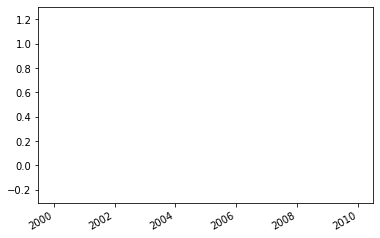

In [15]:
for i in range(0,5):
    find_train_test(i, dataset)

In [ ]:
for i in range(5,10):
    find_train_test(i, data201908)


## Grid Search for ElasticNet

### split train and test

In [52]:
def train_test(df, index):
    i = index
    reverse_list = df.조사일자.drop_duplicates().sort_values(ascending=False).tolist()    
    return df[df.조사일자.dt.date < reverse_list[i]], df[df.조사일자.dt.date >= reverse_list[i]]

train1, test1 = train_test(data201908, 7)
X_train1, Y_train1 = split_xy(train1)
X_test1, Y_test1 = split_xy(test1)

train2, test2 = train_test(data201907, 7)
X_train2, Y_train2 = split_xy(train2)
X_test2, Y_test2 = split_xy(test2)

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, mean_squared_error

### search proper params

In [54]:
def grid_search(X_train, Y_train, X_test, Y_test):
    # Use grid search to tune the parameters:
    params ={
                "max_iter": [1, 5, 10], # , 50, 100, 500, 1000],
                "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                "l1_ratio": np.arange(0.0, 1.0, 0.1)
            }

    eNet = ElasticNet()
    tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(eNet, params, scoring=make_scorer(customized_rmse, greater_is_better=False), cv=tscv.split(X_train))
    grid.fit(X_train, Y_train)
    return grid

In [55]:
grid1 = grid_search(X_train1, Y_train1, X_test1, Y_test1)

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125.46536745891646, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248.54710233955774, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372.6813159231018, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.653852110717025, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.00954568439064, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362.2660025831306, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.686040633264014, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.96859530671159, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 353.68165216066336, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.0156326849233, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1132.5431730553241, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379.60733762423274, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1053.7564698682227, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.8190734003955, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 432.30267801532796, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 875.2173352815727, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1399.6136604041737, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.859077728075391, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678.0527322903272, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3331.437114491313, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4966.388574901806, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.911521755278045, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 708.0998838687647, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2634.0281785725424, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3381.650462424156, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6714.918984645354, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10028.480773962336, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

### searhed best params

In [57]:
grid1.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.9, 'max_iter': 10}

### test bset estimator

In [58]:
elastic_net = grid1.best_estimator_
elastic_net

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=10, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [86]:
def test_estimator(X_train, Y_train, X_test, Y_test):
    print("********* For fianl model *********")
    
    # retrain model
    elastic_net = grid1.best_estimator_
    elastic_net.fit(X_train, Y_train)
    print("score for train/test: {train}/{test}".format(
        train=elastic_net.score(X_train, Y_train), test=elastic_net.score(X_test, Y_test))
    )
    
    # customized RMSE metrics for testset
    Y_pred = pd.Series(elastic_net.predict(X_test))
    r_pred = np.expm1(Y_pred).rename("pred")
    r_test = np.expm1(Y_test).rename("test").reset_index(drop=True)

    print("---test & pred---")
    print(r_test.to_frame().join(r_pred))
    print("customized rmse: ", customized_rmse(r_test, r_pred))
    return elastic_net

# ela = test_estimator(X_train, Y_train, X_test, Y_test) 
# plot_coef(ela)

ela1 = test_estimator(X_train1, Y_train1, X_test1, Y_test1) 
ela2 = test_estimator(X_train2, Y_train2, X_test2, Y_test2) 

# Y_pred = elastic_net.predict(X_test)

********* For fianl model *********
score for train/test: 0.9725838253973863/0.9598959925335062
---test & pred---
              test         pred
0       238.000000   222.769069
1       870.000000   980.949745
2       990.000000  1234.684649
3      1320.000000  1191.898400
4      1050.000000   953.214863
...            ...          ...
15347  1566.000000  1423.261884
15348  1166.000000  1325.172913
15349   714.000000   629.416059
15350  1058.000000   812.283206
15351  2016.666667  1214.818315

[15352 rows x 2 columns]
customized rmse:  593.9406734398068
********* For fianl model *********


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 422.0252481361356, tolerance: 2.661601832948214
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474.0188527091915, tolerance: 3.01656320582926
  positive)


score for train/test: 0.9761425840185298/0.9646916194502201
---test & pred---
              test         pred
0       258.000000   232.973331
1      1450.000000  1008.760912
2      1050.000000  1354.967176
3      1120.000000  1073.748274
4      1120.000000   937.578751
...            ...          ...
15451  1566.000000  1569.514129
15452  1166.000000  1356.528559
15453   714.000000   624.593173
15454  1058.000000   848.484018
15455  2383.333333  2593.798280

[15456 rows x 2 columns]
customized rmse:  582.8808081026499


### coef graph

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']

def plot_coef(model, X_train):
    coef = pd.Series(model.coef_, index=X_train.columns)
    coef_sort = coef.sort_values(ascending=False)
    sns.barplot(x=coef_sort.values, y=coef_sort.index)
    return coef_sort

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 46160 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48521 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49709 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\

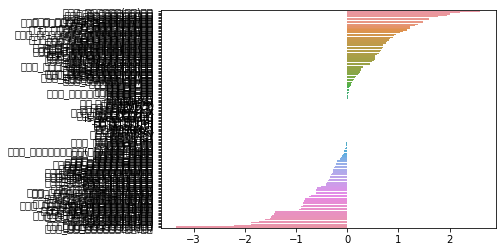

In [101]:
coef_series = plot_coef(ela1, X_train1)

품목명_수박수박수박(일반)일반       2.58821
품목명_한우쇠고기안심안심          2.18445
품목명_한우쇠고기등심한우등심        1.99201
품목명_포도포도거봉거봉           1.92981
품목명_메론멜론네트계일반          1.76361
                        ...   
품목명_감자감자수미수미          -1.73316
품목명_열무열무열무(일반)일반      -1.87884
품목명_배추얼갈이배추얼갈이배추일반    -1.89022
품목명_양파양파기타양파(일반)      -2.20527
품목명_미나리미나리미나리(일반)일반   -3.33811
Length: 150, dtype: float64

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 52380 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47308 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44405 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\

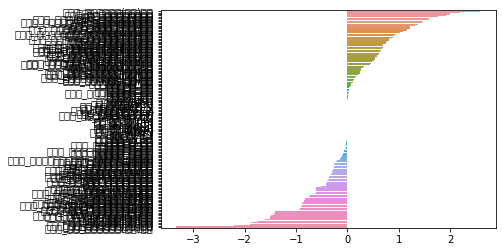

In [390]:
plot_coef(ela2, X_train2)

In [139]:
pd.options.display.float_format = '{:,.200f}'.format

final = coef_series.reset_index().rename(columns={"index": "col", 0: "val"})
absolute = final.assign(absolute = lambda x: abs(x.val))
absolute.sort_values("absolute", ascending=True).head(50).drop("val", axis=1)

,col,absolute
74,평균 기온(°C),0.000000000000000000000000000000000000000000000...
81,최고 파주기(sec),0.000000000000000000000000000000000000000000000...
80,평균 파주기(sec),0.000000000000000000000000000000000000000000000...
79,season_3,0.000000000000000000000000000000000000000000000...
78,최고 최대 파고(m),0.000000000000000000000000000000000000000000000...
77,최고 유의 파고(m),0.000000000000000000000000000000000000000000000...
76,평균 유의 파고(m),0.000000000000000000000000000000000000000000000...
75,평균 최대 파고(m),0.000000000000000000000000000000000000000000000...
72,품목명_배배원황원황,0.000000000000000000000000000000000000000000000...
71,품목명_명태류명태명태냉동,0.000000000000000000000000000000000000000000000...


In [130]:
absolute.sort_values("absolute", ascending=False).drop("val", axis=1)[60:120]

,col,absolute
32,품목명_사과사과후지후지,0.543829
33,품목명_젓갈(일반)류새우젓새우젓일반,0.534303
34,품목명_생강생강생강(일반)국산,0.523468
121,품목명_참깨참깨참깨(수입)인도참깨,0.502984
35,품목명_돈육돼지고기목심살목살,0.487366
36,품목명_대파파대파(일반)대파,0.453646
37,품목명_쇠고기쇠고기갈비살(수입)미국산갈비살,0.452988
120,품목명_상추상추적상추적,0.414923
119,품목명_오이오이취청취청,0.405595
118,품목명_상추상추청상추청,0.392304


In [132]:
absolute.sort_values("absolute", ascending=False).drop("val", axis=1)[119:180]

,col,absolute
90,품목명_당근당근흙당근무세척,0.011027
60,조사지역명_부산,0.007004
89,강수 계속시간(hr),0.004867
88,조사지역명_경북포항,0.004144
87,평균기온(°C),0.003117
61,최저기온(°C),0.002827
86,조사지역명_전남순천,0.001902
85,최고기온(°C),0.000655
62,평균기압(hPa),0.000606
84,평균 풍속(m/s)_y,0.000560


In [ ]:

m_list = ['평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '최대 풍속(m/s)', '평균 풍속(m/s)', '최소 상대습도(pct)', '평균 상대습도(pct)', '합계 일조시간(hr)', '강수 계속시간(hr)', '일강수량(mm)']

def func(x):
    print(final[final.col == x])
    return None

list(map(func , m_list))